<a href="https://colab.research.google.com/github/ChaimElchik/GPS-Demo/blob/main/GPS_DEM_DepthAnything.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Elephant Detection and GPS Localization Demo 🐘📍

Welcome! This Colab notebook allows you to upload a single drone image, detect elephants within it using a YOLO model, and estimate their GPS coordinates.

**How to use:**
1.  Run the "Setup" cell to install necessary libraries and download the model.
2.  Run the "Upload Image" cell and select a JPG image from your computer.
3.  Run the "Process Image and Get Results" cell. This will perform detection, calculate GPS, and display the results.
4.  The results (image with IDs, coordinates CSV, distances CSV) will be displayed and made available for download.

---
## 1. Setup Environment

In [1]:
# Install necessary packages
!pip install ultralytics piexif geopy pyproj torch torchvision transformers timm accelerate -q
!apt-get install -y exiftool -qq

# Import necessary libraries
import cv2
import torch
import numpy as np
from ultralytics import YOLO
import pandas as pd
import time
import os
from pathlib import Path
import matplotlib.pyplot as plt
from pyproj import Transformer
import math
import re
from datetime import datetime, timedelta
import subprocess
import json
import csv
from google.colab import files
from PIL import Image
import io
from geopy.distance import geodesic
from IPython.display import Image as IPImage, display

# Create output directories
os.makedirs("Detections", exist_ok=True)
os.makedirs("Processed_Output", exist_ok=True)

print("\nSetup Complete!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 26.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 92.2 MB/s eta 0:00:00
Selecting previously unselected package libarchive-zip-perl.
(Reading database ... 126319 files and directories currently insta


##  Upload Model

Download the Model from https://github.com/ChaimElchik/GPS-Demo/blob/main/best_xl.pt

In [2]:
print("Please upload 'best_xl.pt':")
uploaded_model = files.upload()
if 'best_xl.pt' not in uploaded_model:
  print("\nERROR: 'best_xl.pt' was not uploaded. Please upload the model file to proceed.")
else:
  print("\nModel 'best_xl.pt' uploaded successfully!")

Please upload 'best_xl.pt':


Saving best_xl.pt to best_xl.pt

Model 'best_xl.pt' uploaded successfully!


---
## 2. Upload Your Image

Please upload a single JPG image:


Saving tmp_1748517407958.jpg to tmp_1748517407958.jpg

Loaded and saved image: tmp_1748517407958.jpg


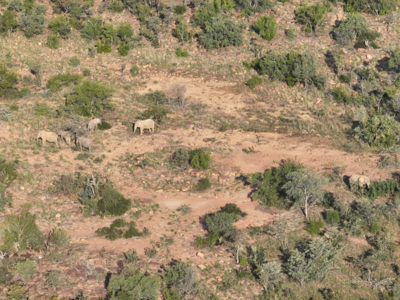

In [9]:
from google.colab import files
import io
from PIL import Image

# Upload image
print("Please upload a single JPG image:")
uploaded = files.upload()

# Load and save the uploaded image
uploaded_image_path = None
for fn in uploaded.keys():
    if fn.lower().endswith('.jpg') or fn.lower().endswith('.jpeg'):
        uploaded_image_path = f"/content/{fn}"
        with open(uploaded_image_path, 'wb') as f:
            f.write(uploaded[fn])
        print(f"\nLoaded and saved image: {fn}")

        # Display the uploaded image
        img_display = Image.open(io.BytesIO(uploaded[fn]))
        img_display.thumbnail((400, 400)) # Resize for display
        display(img_display)
        break # Process only the first uploaded JPG

if not uploaded_image_path:
    print("\nERROR: No JPG image was uploaded. Please run this cell again and upload a valid image.")

---
## 3. Process Image and Get Results

INFO: Using Sensor Size 17.3mm x 13.0mm (Mavic 3 Pro Main Cam).
INFO: Using device: cpu for deep learning models.
Starting processing for: /content/tmp_1748517407958.jpg
Running detection on /content/tmp_1748517407958.jpg...
Detection complete. Found 7 objects. Saved to Detections/tmp_1748517407958.txt.
Waiting for file: Detections/tmp_1748517407958.txt...
File found: Detections/tmp_1748517407958.txt
Loading bounding boxes from Detections/tmp_1748517407958.txt...
Loaded 7 bounding boxes.

--- Starting GPS Pipeline ---
Extracting metadata...
Running exiftool...
exiftool successful.
  RelativeAltitude: +86.000, AbsoluteAltitude: +117726280.000
Metadata extraction successful.
INFO: Contacting OpenTopoData API for coordinates -24.226734, 27.827064...


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.opentopodata.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(



INFO: Using base AGL of 86.00m from drone's RelativeAltitude to scale the depth map.

INFO: Loading depth estimation model 'depth-anything/Depth-Anything-V2-Large-hf'...
INFO: Generating depth map...
INFO: Depth map generated successfully.
INFO: Scaled depth map using factor 0.48. Mean depth is now ~86.00m.
  Camera Intrinsics (K): fx=6901.7, fy=6888.5, cx=2000.0, cy=1500.0
  Using Angles (YPR): Yaw=170.20, Pitch=-16.70, Roll=0.00
  Rotation Matrix (R) calculated using corrected coordinate system logic.

Calculating GPS for each bounding box using depth map...
  Processing Box 1 at pixel (940.2, 1252.2)...
    -> Depth at pixel (940, 1252): 73.23m
    -> NED offsets (m): N=-67.12, E=22.87
    -> GPS: -24.227340, 27.827289
  Processing Box 2 at pixel (468.4, 1388.6)...
    -> Depth at pixel (468, 1389): 84.33m
    -> NED offsets (m): N=-74.96, E=31.48
    -> GPS: -24.227410, 27.827374
  Processing Box 3 at pixel (832.4, 1447.8)...
    -> Depth at pixel (832, 1448): 85.71m
    -> NED of

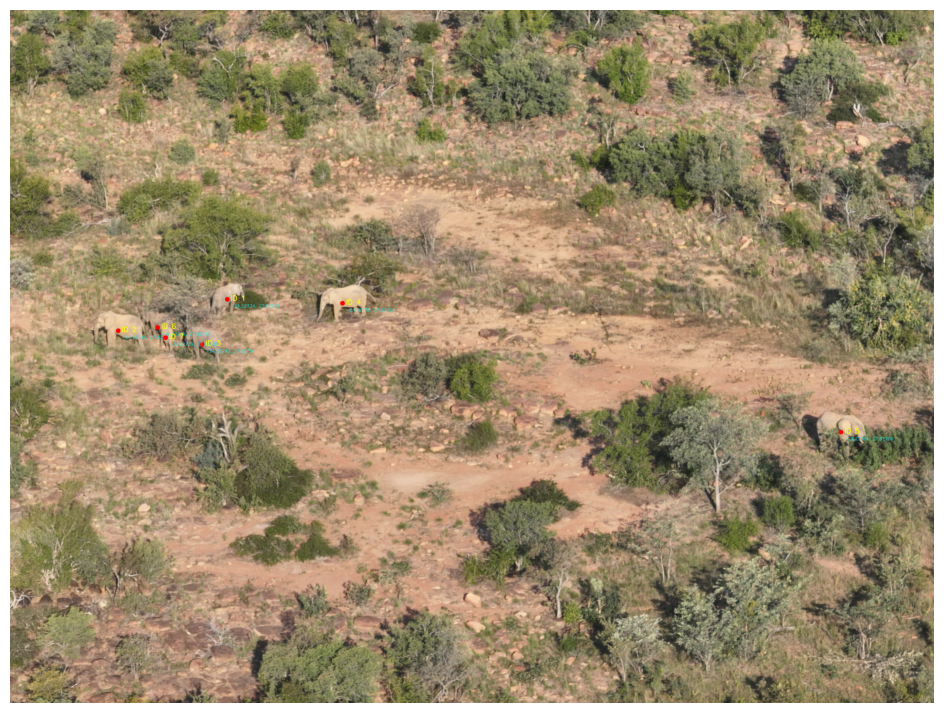


Zipping and downloading output folders...

Created 'Processed_Output.zip'. Initiating download...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Created 'Detections.zip'. Initiating download...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [10]:
# --- Import Libraries ---
import os
import cv2
import numpy as np
import subprocess
import json
import re
import math
import time
import traceback
import csv
from pathlib import Path
import requests
import torch
from transformers import AutoImageProcessor, AutoModelForDepthEstimation
from PIL import Image
import shutil # <-- NEW: For zipping files
import matplotlib.pyplot as plt # <-- NEW: For displaying images

# --- Dependencies Check ---
try:
    from ultralytics import YOLO
    from geopy.distance import geodesic
    from geopy.point import Point
    from google.colab import files # <-- MODIFIED: Ensure files is imported
    from IPython.display import display, Image as IPImage
except ImportError as e:
    print(f"ERROR: Missing dependency - {e}. Please install required libraries.")
    print("Run: pip install ultralytics opencv-python pyproj geopy ipython requests torch torchvision transformers timm accelerate Pillow")
    exit()

# --- Global Configuration ---
OUTPUT_DIR_DETECTIONS = "Detections"
OUTPUT_DIR_PROCESSED = "Processed_Output"
MODEL_PATH = "best_xl.pt"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEPTH_MODEL_NAME = 'depth-anything/Depth-Anything-V2-Large-hf'

# --- SENSOR CONFIGURATION ---
SENSOR_WIDTH_MM = 17.3
SENSOR_HEIGHT_MM = 13.0
print(f"INFO: Using Sensor Size {SENSOR_WIDTH_MM}mm x {SENSOR_HEIGHT_MM}mm (Mavic 3 Pro Main Cam).")
print(f"INFO: Using device: {DEVICE} for deep learning models.")

os.makedirs(OUTPUT_DIR_DETECTIONS, exist_ok=True)
os.makedirs(OUTPUT_DIR_PROCESSED, exist_ok=True)


# --- Define Helper Functions ---
# NOTE: All functions from get_depth_map to image_point_to_gps_from_depth are unchanged from the previous version.
# They are included here for completeness.
def get_depth_map(image_path, model_name):
    print(f"\nINFO: Loading depth estimation model '{model_name}'...")
    try:
        image = Image.open(image_path).convert("RGB")
        image_processor = AutoImageProcessor.from_pretrained(model_name)
        model = AutoModelForDepthEstimation.from_pretrained(model_name).to(DEVICE)
        print("INFO: Generating depth map...")
        inputs = image_processor(images=image, return_tensors="pt").to(DEVICE)
        with torch.no_grad():
            outputs = model(**inputs)
            predicted_depth = outputs.predicted_depth
        prediction = torch.nn.functional.interpolate(
            predicted_depth.unsqueeze(1),
            size=image.size[::-1],
            mode="bicubic",
            align_corners=False,
        )
        output = prediction.squeeze().cpu().numpy()
        print("INFO: Depth map generated successfully.")
        return output
    except Exception as e:
        print(f"ERROR: Failed to generate depth map. Error: {e}")
        return None

def Find_Elephants(image_path):
    if not os.path.exists(MODEL_PATH):
        print(f"ERROR: Model file '{MODEL_PATH}' not found.")
        return None, None
    try:
        model = YOLO(MODEL_PATH)
        print(f"Running detection on {image_path}...")
        results = model.predict(source=image_path, conf=0.6, verbose=False)
        im1 = cv2.imread(image_path)
        if im1 is None: raise FileNotFoundError(f"Could not read image: {image_path}")
        height, width, _ = im1.shape
        base_name = Path(image_path).stem
        yolo_format_data = []
        num_objects = 0
        for box in results[0].boxes:
            num_objects += 1
            cls = int(box.cls[0])
            conf = float(box.conf[0])
            x1, y1, x2, y2 = map(float, box.xyxy[0])
            cv2.rectangle(im1, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
            cv2.putText(im1, f'Class: {cls}, Conf: {conf:.2f}', (int(x1), int(y1) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
            xmin_norm, ymin_norm, xmax_norm, ymax_norm = x1/width, y1/height, x2/width, y2/height
            yolo_format_data.append(f"{cls} {conf:.6f} {xmin_norm:.6f} {ymin_norm:.6f} {xmax_norm:.6f} {ymax_norm:.6f}")
        output_image_path = os.path.join(OUTPUT_DIR_DETECTIONS, f"{base_name}_detection.jpg")
        output_txt_path = os.path.join(OUTPUT_DIR_DETECTIONS, f"{base_name}.txt")
        cv2.imwrite(output_image_path, im1)
        with open(output_txt_path, 'w') as f: f.write("\n".join(yolo_format_data))
        print(f"Detection complete. Found {num_objects} objects. Saved to {output_txt_path}.")
        return output_txt_path, output_image_path
    except Exception as e:
        print(f"ERROR during elephant detection: {e}")
        traceback.print_exc()
        return None, None

def extract_exiftool_metadata(image_path):
    try:
        print("Running exiftool...")
        result = subprocess.run(['exiftool', '-j', '-n', '-G', image_path], stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True, check=True)
        print("exiftool successful.")
        return json.loads(result.stdout)[0]
    except FileNotFoundError: raise RuntimeError("ERROR: 'exiftool' not found. Is it installed and in PATH?")
    except subprocess.CalledProcessError as e: raise RuntimeError(f"exiftool failed: {e.stderr}")
    except Exception as e: raise RuntimeError(f"ERROR processing exiftool output: {e}")

def dms_to_decimal(dms_val, ref):
    if isinstance(dms_val, (int, float)): decimal = float(dms_val)
    else:
        match = re.search(r'(\d+)[^0-9.]*(\d*)[^0-9.]*([\d.]+)', str(dms_val).strip(), re.IGNORECASE)
        if not match: raise ValueError(f"Invalid DMS format: {dms_val}")
        degrees, minutes, seconds = match.groups()
        decimal = float(degrees) + (float(minutes) if minutes else 0.0)/60 + float(seconds)/3600
    if ref and ref.upper() in ['S', 'W']: decimal = -decimal
    return decimal

def get_metadata_value(metadata, keys, default=None):
    for key in keys:
        value = metadata.get(key)
        if value is not None: return value
    return default

def get_dem_elevation_from_api(latitude, longitude):
    print(f"INFO: Contacting OpenTopoData API for coordinates {latitude:.6f}, {longitude:.6f}...")
    try:
        url = f"https://api.opentopodata.org/v1/eudem25m?locations={latitude},{longitude}"
        response = requests.get(url, verify=False)
        if response.status_code == 200:
            data = response.json()
            elevation = data['results'][0]['elevation']
            if elevation is None:
                print("WARNING: API returned 'null' for elevation. Coordinates may be over water or out of bounds.")
                return None
            print(f"INFO: API lookup successful. Ground elevation: {elevation}m")
            return elevation
        else:
            print(f"WARNING: API returned status code {response.status_code}. Unable to get elevation.")
            return None
    except requests.exceptions.RequestException as e:
        print(f"WARNING: API request failed. Error: {e}")
        return None

def extract_metadata(image_path):
    print("Extracting metadata...")
    metadata = extract_exiftool_metadata(image_path)
    rel_alt_val = get_metadata_value(metadata, ['XMP:RelativeAltitude', 'EXIF:RelativeAltitude'])
    abs_alt_val = get_metadata_value(metadata, ['XMP:AbsoluteAltitude', 'EXIF:AbsoluteAltitude', 'Composite:GPSAltitude'])
    pitch_val = get_metadata_value(metadata, ['XMP:GimbalPitchDegree', 'EXIF:GimbalPitchDegree', 'Composite:GimbalPitch'])
    yaw_val = get_metadata_value(metadata, ['XMP:GimbalYawDegree', 'EXIF:GimbalYawDegree', 'Composite:GimbalYaw'], default=0.0)
    roll_val = get_metadata_value(metadata, ['XMP:GimbalRollDegree', 'EXIF:GimbalRollDegree', 'Composite:GimbalRoll'], default=0.0)
    focal_len_val = get_metadata_value(metadata, ['EXIF:FocalLength'])
    img_width_val = get_metadata_value(metadata, ['EXIF:ImageWidth', 'File:ImageWidth'])
    img_height_val = get_metadata_value(metadata, ['EXIF:ImageHeight', 'File:ImageHeight'])
    gps_lat_val = get_metadata_value(metadata, ['EXIF:GPSLatitude', 'Composite:GPSLatitude'])
    gps_lon_val = get_metadata_value(metadata, ['EXIF:GPSLongitude', 'Composite:GPSLongitude'])
    gps_lat_ref = get_metadata_value(metadata, ['EXIF:GPSLatitudeRef'])
    gps_lon_ref = get_metadata_value(metadata, ['EXIF:GPSLongitudeRef'])
    print(f"  RelativeAltitude: {rel_alt_val}, AbsoluteAltitude: {abs_alt_val}")
    essential = {'RelativeAltitude': rel_alt_val, 'AbsoluteAltitude': abs_alt_val, 'GimbalPitch': pitch_val, 'FocalLength': focal_len_val, 'ImageWidth': img_width_val, 'ImageHeight': img_height_val, 'GPSLatitude': gps_lat_val, 'GPSLongitude': gps_lon_val}
    missing = [k for k, v in essential.items() if v is None]
    if missing: raise ValueError(f"Missing essential EXIF tags: {missing}")
    rel_alt = float(rel_alt_val)
    abs_alt = float(abs_alt_val)
    pitch_deg, yaw_deg, roll_deg = float(pitch_val), float(yaw_val), float(roll_val)
    focal_length_mm = float(str(focal_len_val).split(' ')[0])
    img_width, img_height = int(img_width_val), int(img_height_val)
    latitude = dms_to_decimal(gps_lat_val, gps_lat_ref)
    longitude = dms_to_decimal(gps_lon_val, gps_lon_ref)
    print("Metadata extraction successful.")
    return (latitude, longitude, rel_alt, abs_alt, pitch_deg, yaw_deg, roll_deg, focal_length_mm, SENSOR_WIDTH_MM, SENSOR_HEIGHT_MM, img_width, img_height)

def get_camera_intrinsics(f_mm, s_w_mm, s_h_mm, i_w, i_h):
    fx = i_w * f_mm / s_w_mm
    fy = i_h * f_mm / s_h_mm
    cx, cy = i_w / 2, i_h / 2
    print(f"  Camera Intrinsics (K): fx={fx:.1f}, fy={fy:.1f}, cx={cx:.1f}, cy={cy:.1f}")
    return np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]])

def get_rotation_matrix(pitch_deg, yaw_deg, roll_deg):
    print(f"  Using Angles (YPR): Yaw={yaw_deg:.2f}, Pitch={pitch_deg:.2f}, Roll={roll_deg:.2f}")
    yaw, pitch, roll = map(math.radians, [yaw_deg, pitch_deg, roll_deg])
    Rz = np.array([[math.cos(yaw), -math.sin(yaw), 0], [math.sin(yaw),  math.cos(yaw), 0], [0, 0, 1]])
    Ry = np.array([[math.cos(pitch), 0, math.sin(pitch)], [0, 1, 0], [-math.sin(pitch), 0, math.cos(pitch)]])
    Rx = np.array([[1, 0, 0], [0, math.cos(roll), -math.sin(roll)], [0, math.sin(roll),  math.cos(roll)]])
    R_gimbal = Rz @ Ry @ Rx
    R_cam_to_body = np.array([[0, 1, 0], [0, 0, 1], [1, 0, 0]]).T
    R = R_gimbal @ R_cam_to_body
    print("  Rotation Matrix (R) calculated using corrected coordinate system logic.")
    return R

def calculate_destination_gps(origin_lat, origin_lon, east_m, north_m):
    if east_m is None or north_m is None: return None, None
    try:
        bearing = math.degrees(math.atan2(east_m, north_m))
        distance_meters = math.hypot(east_m, north_m)
        destination = geodesic(meters=distance_meters).destination(Point(origin_lat, origin_lon), bearing)
        return destination.latitude, destination.longitude
    except Exception as e:
        print(f"ERROR calculating destination GPS: {e}")
        return None, None

def image_point_to_gps_from_depth(u, v, K, R, o_lat, o_lon, abs_depth_map):
    v_idx, u_idx = int(round(v)), int(round(u))
    if not (0 <= v_idx < abs_depth_map.shape[0] and 0 <= u_idx < abs_depth_map.shape[1]):
        print(f"  Warning: Pixel ({u},{v}) is outside of depth map bounds, skipping.")
        return None, None
    distance_to_target = abs_depth_map[v_idx, u_idx]
    print(f"    -> Depth at pixel ({u_idx}, {v_idx}): {distance_to_target:.2f}m")
    K_inv = np.linalg.inv(K)
    ray_cam = K_inv @ np.array([u, v, 1])
    ray_cam_unit = ray_cam / np.linalg.norm(ray_cam)
    point_in_cam_coords = ray_cam_unit * distance_to_target
    ned_offsets = R @ point_in_cam_coords
    ned_n, ned_e = ned_offsets[0], ned_offsets[1]
    print(f"    -> NED offsets (m): N={ned_n:.2f}, E={ned_e:.2f}")
    return calculate_destination_gps(o_lat, o_lon, ned_e, ned_n)

def run_pipeline(image_path, bounding_boxes, use_depth_model=True, use_dem_api=True):
    ALTITUDE_UNIT_CORRECTION_FACTOR = 1.0 # 1.0 for meters, 0.3048 for feet
    print("\n--- Starting GPS Pipeline ---")
    try:
        lat, lon, rel_alt, abs_alt, pitch, yaw, roll, f_mm, s_w, s_h, i_w, i_h = extract_metadata(image_path)
    except Exception as e:
        print(f"FATAL ERROR extracting metadata: {e}. Cannot proceed.")
        return None
    rel_alt = rel_alt * ALTITUDE_UNIT_CORRECTION_FACTOR
    base_agl = rel_alt
    agl_source_msg = "drone's RelativeAltitude"
    if ALTITUDE_UNIT_CORRECTION_FACTOR != 1.0: agl_source_msg += " (corrected from feet)"
    if use_dem_api:
        ground_elevation = get_dem_elevation_from_api(lat, lon)
        if ground_elevation is not None:
            if 0 < abs_alt < 80000:
                base_agl = abs_alt - ground_elevation
                agl_source_msg = f"API DEM (AGL = {abs_alt:.2f}m - {ground_elevation:.2f}m)"
            else:
                print(f"WARNING: AbsoluteAltitude ({abs_alt:.2f}m) is corrupt. Using {agl_source_msg} instead.")
        else:
            print(f"WARNING: DEM API lookup failed. Using {agl_source_msg} instead.")
    print(f"\nINFO: Using base AGL of {base_agl:.2f}m from {agl_source_msg} to scale the depth map.")
    if not use_depth_model:
        print("INFO: Depth model disabled. This script requires the depth model to function.")
        return None
    absolute_depth_map = None
    relative_depth_map = get_depth_map(image_path, DEPTH_MODEL_NAME)
    if relative_depth_map is not None:
        mean_relative_depth = np.mean(relative_depth_map)
        if mean_relative_depth > 1e-6:
            scale_factor = base_agl / mean_relative_depth
            absolute_depth_map = relative_depth_map * scale_factor
            print(f"INFO: Scaled depth map using factor {scale_factor:.2f}. Mean depth is now ~{np.mean(absolute_depth_map):.2f}m.")
        else:
            print("WARNING: Mean relative depth is zero or invalid, cannot scale depth map.")
            return None
    else:
        print("WARNING: Depth map generation failed. Cannot proceed.")
        return None
    K = get_camera_intrinsics(f_mm, s_w, s_h, i_w, i_h)
    R = get_rotation_matrix(pitch, yaw, roll)
    gps_results = []
    print("\nCalculating GPS for each bounding box using depth map...")
    for i, box in enumerate(bounding_boxes, start=1):
        xmin_norm, ymin_norm, xmax_norm, ymax_norm = box
        center_u = ((xmin_norm + xmax_norm) / 2) * i_w
        center_v = ((ymin_norm + ymax_norm) / 2) * i_h
        print(f"  Processing Box {i} at pixel ({center_u:.1f}, {center_v:.1f})...")
        try:
            gps_lat, gps_lon = image_point_to_gps_from_depth(center_u, center_v, K, R, lat, lon, absolute_depth_map)
            if gps_lat is not None:
                gps_results.append((i, (center_u, center_v), (gps_lat, gps_lon)))
                print(f"    -> GPS: {gps_lat:.6f}, {gps_lon:.6f}")
            else:
                print(f"    -> Could not get GPS for Box {i}.")
        except Exception as e:
            print(f"    -> ERROR calculating GPS for Box {i}: {e}")
            traceback.print_exc()
    print("--- GPS Pipeline Finished ---")
    return gps_results

def load_bounding_boxes_from_txt(txt_path):
    boxes = []
    if not os.path.exists(txt_path):
        print(f"ERROR: Txt file not found at {txt_path}")
        return None
    print(f"Loading bounding boxes from {txt_path}...")
    with open(txt_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) == 6:
                _, _, xmin, ymin, xmax, ymax = map(float, parts)
                boxes.append((xmin, ymin, xmax, ymax))
    print(f"Loaded {len(boxes)} bounding boxes.")
    return boxes

def save_and_display_results(image_path, results, base_name):
    """MODIFIED: Saves results and displays the final image in the notebook."""
    img = cv2.imread(image_path)
    if img is None: return

    output_dir = "Processed_Output"
    csv_path = os.path.join(output_dir, f"{base_name}_coordinates.csv")
    dist_csv_path = os.path.join(output_dir, f"{base_name}_distances.csv")
    img_path = os.path.join(output_dir, f"{base_name}_processed.jpg")

    with open(csv_path, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['ObjectID', 'Latitude', 'Longitude'])
        for obj_id, (_, _), (lat, lon) in results:
            writer.writerow([obj_id, f"{lat:.6f}", f"{lon:.6f}"])

    ids = [r[0] for r in results]
    coords = [(r[2][0], r[2][1]) for r in results]
    with open(dist_csv_path, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['ObjectID_1', 'ObjectID_2', 'Distance_meters'])
        for i in range(len(results)):
            for j in range(i + 1, len(results)):
                dist = geodesic(coords[i], coords[j]).meters
                writer.writerow([ids[i], ids[j], f"{dist:.2f}"])

    for obj_id, (u, v), (lat, lon) in results:
        pos = (int(u), int(v))
        cv2.circle(img, pos, 10, (0, 0, 255), -1)
        cv2.putText(img, f"ID {obj_id}", (pos[0] + 15, pos[1] + 5), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2, cv2.LINE_AA)
        cv2.putText(img, f"{lat:.5f}, {lon:.5f}", (pos[0] + 15, pos[1] + 35), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 0), 1, cv2.LINE_AA)

    cv2.imwrite(img_path, img)
    print("\n--- Results ---")
    print(f"Processed image saved to: {img_path}")
    print(f"Coordinates saved to: {csv_path}")
    print(f"Distances saved to: {dist_csv_path}")

    # --- NEW: Display image directly in the notebook ---
    print("\nDisplaying Processed Image:")
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert from BGR to RGB for matplotlib
    plt.figure(figsize=(12, 9))
    plt.imshow(img_rgb)
    plt.axis('off') # Hide axes
    plt.show()


def download_folder_as_zip(folder_path):
    """NEW: Zips a folder and initiates a download in Colab."""
    if not os.path.isdir(folder_path):
        print(f"Error: Folder '{folder_path}' not found.")
        return

    zip_filename = f"{os.path.basename(folder_path)}.zip"
    shutil.make_archive(os.path.basename(folder_path), 'zip', folder_path)

    print(f"\nCreated '{zip_filename}'. Initiating download...")
    files.download(zip_filename)


def wait_for_file(file_path, timeout=10):
    # This function is unchanged
    start_time = time.time()
    print(f"Waiting for file: {file_path}...")
    while not os.path.exists(file_path):
        time.sleep(0.5)
        if time.time() - start_time > timeout:
            print(f"ERROR: Timeout waiting for {file_path}")
            return False
    print(f"File found: {file_path}")
    return True

# --- Main Execution Block ---

if __name__ == '__main__':
  # Check if an image was uploaded from a previous cell
  if 'uploaded_image_path' in locals() and uploaded_image_path and os.path.exists(uploaded_image_path):
      image_to_process = uploaded_image_path
      print(f"Starting processing for: {image_to_process}")

      # --- CONFIGURE YOUR RUN ---
      # Set to True to use the DepthAnything model to correct for terrain.
      USE_DEPTH_MODEL = True
      # Set to True to automatically fetch ground elevation from an online API for the highest accuracy.
      USE_API_FOR_DEM = True

      # --- RUN THE SCRIPT ---
      txt_path, _ = Find_Elephants(image_to_process)
      if txt_path and wait_for_file(txt_path):
          boxes = load_bounding_boxes_from_txt(txt_path)
          if boxes is not None and len(boxes) > 0 :
              gps_results = run_pipeline(image_to_process, boxes, use_depth_model=USE_DEPTH_MODEL, use_dem_api=USE_API_FOR_DEM)
              if gps_results and len(gps_results) > 0:
                  base_name = Path(image_to_process).stem
                  save_and_display_results(image_to_process, gps_results, base_name)

                  # --- NEW: Download the output folders ---
                  print("\nZipping and downloading output folders...")
                  download_folder_as_zip(OUTPUT_DIR_PROCESSED)
                  download_folder_as_zip(OUTPUT_DIR_DETECTIONS)

              else:
                  print("Could not calculate GPS coordinates for any/all boxes.")
          else:
              print("Failed to load bounding boxes from the detection file.")
      else:
          print("Detection failed or detection file not found. Cannot proceed.")
  else:
      print("ERROR: No image was uploaded or found. Please run the 'Upload Image' cell first.")

---
## 4. (Optional) View Coordinates & Distances

In [11]:
import pandas as pd

base_name = None
if 'uploaded_image_path' in locals() and uploaded_image_path:
    base_name = Path(uploaded_image_path).stem

if base_name:
    coords_file = f"Processed_Output/{base_name}_coordinates.csv"
    dists_file = f"Processed_Output/{base_name}_distances.csv"

    if os.path.exists(coords_file):
        print("--- Coordinates (First 10 rows) ---")
        df_coords = pd.read_csv(coords_file)
        print(df_coords.head(10).to_string())
    else:
        print(f"Coordinates file ({coords_file}) not found.")

    if os.path.exists(dists_file):
        print("\n--- Distances (First 10 rows) ---")
        df_dists = pd.read_csv(dists_file)
        print(df_dists.head(10).to_string())
    else:
        print(f"Distances file ({dists_file}) not found.")
else:
    print("Processing hasn't been run yet, or no image was uploaded.")

--- Coordinates (First 10 rows) ---
   ObjectID   Latitude  Longitude
0         1 -24.227340  27.827289
1         2 -24.227410  27.827374
2         3 -24.227433  27.827339
3         4 -24.227356  27.827241
4         5 -24.227636  27.826996
5         6 -24.227393  27.827346
6         7 -24.227395  27.827343

--- Distances (First 10 rows) ---
   ObjectID_1  ObjectID_2  Distance_meters
0           1           2            11.65
1           1           3            11.54
2           1           4             5.24
3           1           5            44.38
4           1           6             8.22
5           1           7             8.16
6           2           3             4.40
7           2           4            14.79
8           2           5            45.86
9           2           6             3.48
